# 기본 패키지 임포트

In [4]:
import numpy as np
import pandas as pd
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import requests
import time
from tqdm import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


텍스트모델

In [5]:
from collections import OrderedDict
import numpy as np
import spacy

class TextRank4Keyword():
    
    def __init__(self):
        self.d = 0.85 
        self.min_diff = 1e-5 
        self.steps = 10 
        self.node_weight = None 

    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            print(key + ' - ' + str(value))
            if i > number:
                break
        
        
    #각 단어에 대해 가중치를 구하는 함수.
    def analyze(self, sentences, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False):

        vocab = self.get_vocab(sentences)
        
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        g = self.get_matrix(vocab, token_pairs)
        
        pr = np.array([1] * len(vocab))
        
        previous_pr = 0
        
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

# 키워드 추출 클래스

In [104]:
def no_space(text):
    text1 = re.sub('&nbsp;|&nbsp;|\n|\t|\r', '', text)
    text2 = re.sub('\n\n','', text1)
    return text2

def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

def load_stopwords(basepath):
    print("불용어셋을 가져오고 있습니다.")
    with open(basepath+'stopwords.txt', 'r') as f:
        list_file = f.readlines()
    return list_file[0].split(",")


class Review_keyword:
    def __init__(self, minimum_count:int)->None:
        self.basepath = input("데이터를 저장하고 불러올 기본 경로를 입력해주세요   ")
        self.minimum_count = minimum_count
        self.name = None
        self.url = None
        self.data = None
        self.stopwords = load_stopwords(self.basepath)
        self.vocab = None
        self.model = None
        
    def search(self) :
        self.name= input("어떤 영화를 검색하시겠습니까? ")
        url = f'https://movie.naver.com/movie/search/result.naver?query={self.name}&section=all&ie=utf8'        
        res = requests.get(url)
        index = 1
        user_dic = {}
        if res.status_code == 200:
            soup=BeautifulSoup(res.text,'lxml')
            for href in soup.find("ul", class_="search_list_1").find_all("li"): 
                print(f"=============={index}번 영화===============")
                print(href.dl.text[:-2])
                user_dic[index] = int(href.dl.dt.a['href'][30:])
                index = index+1
        movie_num = int(input("몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : "))
        code = user_dic[movie_num]
        base_url = f'https://movie.naver.com/movie/bi/mi/pointWriteFormList.nhn?code={code}&type=after&onlyActualPointYn=N&onlySpoilerPointYn=N&order=sympathyScore&page='
        self.url = base_url+'{}'
        
    def save_and_load(self,dataframe):
        dataframe.to_csv(self.basepath+f'{self.name}review.csv' , index= False)
        df = pd.read_csv(self.basepath+f'{self.name}review.csv')
        df = df.dropna()
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)
        return df
            
    def crawl_review(self):
        res = requests.get(self.url)
        if res.status_code == 200:
            soup=BeautifulSoup(res.text,'lxml')
            total = soup.select('div.score_total > strong > em')[0].text
            pages = int(total.replace(',','')[:-1]) #17,921 > 17921로 변환 후 캐스팅
            print()
            print(f"{pages}개의 페이지에서 {self.name} 영화 리뷰를 모으고 있습니다.")
            time.sleep(1)
        comments = []
        stars = []
        for page in tqdm(range(1,pages+1)):
            url = self.url.format(page)
            res = requests.get(url)
            if res.status_code == 200:
                soup=BeautifulSoup(res.text,'lxml')
                star =  soup.select('div.score_result > ul > li > div.star_score > em')
                tds = soup.select('div.score_result > ul > li > div.score_reple > p > span')
                for st in star:
                    stars.append(int(st.text))
                for cmt in tds:
                    if cmt.text != '관람객' and cmt.text !='스포일러가 포함된 감상평입니다. 감상평 보기':
                        comments.append(no_space(cmt.text))
                if(len(comments) != len(stars)):
                    print(url)
                    break 
        assert len(comments) == len(stars)
        self.data = self.save_and_load(pd.DataFrame({"Review":comments, "Rank":stars}))
       
    def load_data(self, filename):
        filepath = self.basepath+filename
        df = pd.read_csv(filepath)
        df = df.dropna()
        df = df.drop_duplicates()
        df = df.reset_index(drop=True)
        self.name = filename[:-10]
        self.data =df
                
        
    
    def make_wordlist(self,reviews): #reviews => data['Review'].tolist()
        print("리뷰들을 모아 분석하는 중입니다.....")
        #정규표현식 적용
        print("데이터 정제 중....")
        reviews = [extract_word(review) for review in reviews]
        #형태소 추출
        print("형태소 추출 중....")
        okt = Okt()
        reviews = [okt.morphs(sent,stem=True) for sent in reviews]
        #한글자 제거
        print("한글자 제거 중....")
        reviews = [[x for x in sent if len(x)>1 or x=="닉"] for sent in reviews ]
        #불용어 제거
        print("불용어 제거 중....")
        reviews = [[x for x in sent if x not in self.stopwords] for sent in reviews]
        reviews = [[x if (x!='재밌다' and x!='재미잇다' and x!= '재밋다') else '재미있다' for x in sent] for sent in reviews]
        word_list = list(set([x for sent in reviews for x in sent ]))
        #최소횟수 미만 제거
        print("의미있는 단어리스트 생성 중....")
        time.sleep(1)
        final = []
        for i in tqdm(range(len(reviews))):
            tmp = reviews[i]
            saved = []
            for word in tmp:
                if word_list.count(word) >= self.minimum_count:
                    saved.append(word)
            final.append(saved)
        return final
        
    def ready_data(self):
        self.search()
        self.crawl_review()
        time.sleep(0.5)
        print("리뷰를 모두 불러왔습니다.")
        
    def extract(self):
        print("데이터를 학습하고 있습니다.")
        feeling = [0 if rank in range(0,7) else 1 for rank in self.data['Rank']]
        self.data['P/N'] = feeling
        print("데이터 라벨링 완료")
        pdata=self.data.get(self.data['P/N']==1)
        ndata=self.data.get(self.data['P/N']==0)
        
        print("긍정 데이터 학습 중")
        cleaned_review = self.make_wordlist(pdata['Review'].tolist())
        tr4w2 = TextRank4Keyword()
        tr4w2.analyze(cleaned_review, window_size=10, lower=False)
        
        print("부정 데이터 학습 중")
        cleaned_reviewn = self.make_wordlist(ndata['Review'].tolist())
        tr4w2n = TextRank4Keyword()
        tr4w2n.analyze(cleaned_reviewn, window_size=10, lower=False)
        
        time.sleep(0.5)
        print("전처리 작업을 완료하였습니다.")
        return tr4w2, tr4w2n
    
    def visualize(self, pmodel, nmodel):
        #폰트설정(한글 깨짐)
        import math
        from matplotlib import font_manager, rc
        font_name = font_manager.FontProperties(fname="font/NanumSquare.ttf").get_name()
        rc('font', family=font_name)
        import matplotlib
        matplotlib.rcParams['axes.unicode_minus'] = False
        
        #긍부정 비율 시각화
        ratio = [self.data['P/N'].tolist().count(x) for x in [1,0]]
        labels = ['Positive', 'Negative']
        colors = ['#ff9999', '#8fd9b6']
        wedgeprops={'width': 0.2, 'edgecolor': 'w', 'linewidth': 5}
        plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, colors=colors, wedgeprops=wedgeprops)
        plt.title(f"영화 {self.name} 리뷰 비중")
        plt.show()
        
        
        #주요 키워드 시각화
        plabel = []
        nlabel = []
        pvalue = []
        nvalue = []
        pnode_weight = OrderedDict(sorted(pmodel.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(pnode_weight.items()):
            plabel.append(key)
            pvalue.append(value)
            if i >= 4:
                break
        nnode_weight = OrderedDict(sorted(nmodel.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(nnode_weight.items()):
            nlabel.append(key)
            nvalue.append(-value)
            if i >= 4:
                break        
        x = np.arange(5)
        
    
        graphlimit = round(max(pvalue+nvalue))+2
        plt.subplot(1,2,1)
        bar1 = plt.barh(nlabel,nvalue, color = "#8fd9b6")

        plt.xlim([-graphlimit,0]) 
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        label_ind = 0
        for rect in bar1:
            witdh = rect.get_width()
            posx = witdh*1.05
            posy = rect.get_y()+rect.get_height()*0.5
            plt.text(posx, posy, nlabel[label_ind], rotation=0, ha='right', va='center')
            label_ind = label_ind+1

        plt.subplot(1,2,2)
        bar2 = plt.barh(plabel, pvalue, color="#ff9999")
        plt.xlim([0,graphlimit]) 
        ax = plt.gca()
        ax.axes.yaxis.set_visible(False)
        label_ind = 0
        for rect in bar2:
            witdh = rect.get_width()
            posx = witdh*1.05
            posy = rect.get_y()+rect.get_height()*0.5
            plt.text(posx, posy, plabel[label_ind], rotation=0, ha='left', va='center')
            label_ind = label_ind+1
        plt.suptitle(f'{self.name} 연관어 BEST 5',fontweight ="bold")
        #plt.subplots_adjust(left=0, bottom=0,  right=1.5, top=0.7, wspace=0.0, hspace=0)
        plt.tight_layout()

# 실행예시

## 원하는 영화 검색하기 (사전 데이터 없는 경우)

In [105]:
cats = Review_keyword(minimum_count = 1)
cats.ready_data()

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.
어떤 영화를 검색하시겠습니까? 캣츠앤독스
==============1번 영화===============

캣츠 앤 독스 (Cats & Dogs)

7.83 (참여 184명)

액션, 모험, 코미디, 가족| 미국, 오스트레일리아|85분 |2001
감독 : 로렌스 구터먼|출연 : 알렉 볼드윈, 마이클 클락 던칸, 션 헤이즈, 존 로비츠, 토비 맥과이어, 조 판톨리아노, 수잔 서랜든


==============2번 영화===============

캣츠 앤 독스 2 (Cats & Dogs: The Revenge Of Kitty Galore)

7.58 (참여 248명)

액션, 코미디, 가족| 미국, 오스트레일리아|82분 |2010
감독 : 브래드 페이튼|출연 : 크리스 오도넬, 베트 미들러, 닉 놀테, 제임스 마스던, 크리스티나 애플게이트, 캣 윌리엄스, 닐 패트릭 해리스, 션 헤이즈, 월리스 쇼운, 로저 무어, 조 판톨리아노, 마이클 클락 던칸


==============3번 영화===============

오브 캣츠, 독스, 팜 애니멀즈 앤 사시미 (Of Cats, Dogs, Farm Animals and Sashimi)
다큐멘터리| 필리핀|77분 |2015
감독 : 페리 다이즌

몇 번 영화를 선택하시겠습니까? (숫자만 입력)  : 2

24개의 페이지에서 캣츠앤독스 영화 리뷰를 모으고 있습니다.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  9.39it/s]


리뷰를 모두 불러왔습니다.


In [106]:
pmodel, nmodel = cats.extract()

데이터를 학습하고 있습니다.
데이터 라벨링 완료
긍정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|█████████████████████████████████████████████████████████████████████████████| 174/174 [00:00<00:00, 43630.59it/s]


부정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|███████████████████████████████████████████████████████████████████████████████| 63/63 [00:00<00:00, 65568.52it/s]


전처리 작업을 완료하였습니다.


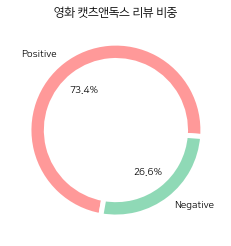

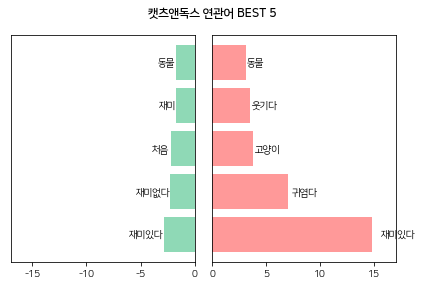

In [107]:
cats.visualize(pmodel, nmodel)

## 리뷰 데이터가 있는 경우 (파일 업로드해서 분석)

In [111]:
iron = Review_keyword(minimum_count = 1)
iron.load_data('아이언맨2review.csv')

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.


In [112]:
pmodel, nmodel = iron.extract()

데이터를 학습하고 있습니다.
데이터 라벨링 완료
긍정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|████████████████████████████████████████████████████████████████████████████| 4324/4324 [00:01<00:00, 2570.50it/s]


부정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|████████████████████████████████████████████████████████████████████████████| 2093/2093 [00:00<00:00, 2896.98it/s]


전처리 작업을 완료하였습니다.


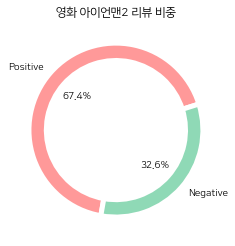

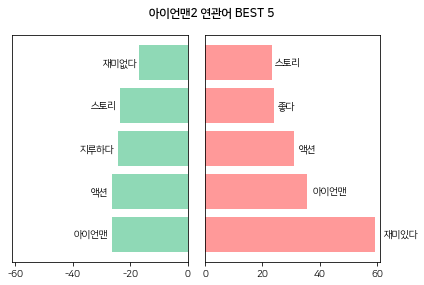

In [114]:
iron.visualize(pmodel,nmodel)

## 실행예시 - 주토피아

In [115]:
zoo = Review_keyword(minimum_count = 1)
zoo.load_data('주토피아review.csv')

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.


In [117]:
pmodel, nmodel = zoo.extract()

데이터를 학습하고 있습니다.
데이터 라벨링 완료
긍정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|███████████████████████████████████████████████████████████████████████████| 17278/17278 [00:22<00:00, 764.24it/s]


부정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|██████████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6755.24it/s]


전처리 작업을 완료하였습니다.


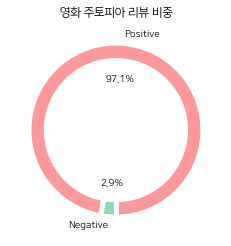

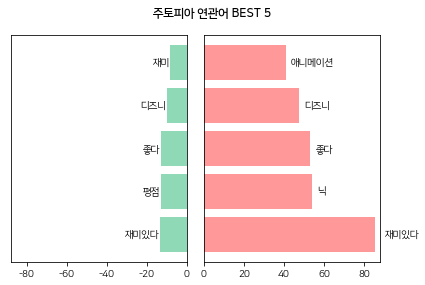

In [118]:
zoo.visualize(pmodel,nmodel)

## 실행예시 - 살아있다

In [123]:
alive = Review_keyword(minimum_count = 1)
alive.load_data('살아있다review.csv')

데이터를 저장하고 불러올 기본 경로를 입력해주세요   data/
불용어셋을 가져오고 있습니다.


In [124]:
pmodel, nmodel = alive.extract()

데이터를 학습하고 있습니다.
데이터 라벨링 완료
긍정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|████████████████████████████████████████████████████████████████████████████| 1870/1870 [00:00<00:00, 6066.91it/s]


부정 데이터 학습 중
리뷰들을 모아 분석하는 중입니다.....
데이터 정제 중....
형태소 추출 중....
한글자 제거 중....
불용어 제거 중....
의미있는 단어리스트 생성 중....


100%|██████████████████████████████████████████████████████████████████████████████| 893/893 [00:00<00:00, 6732.54it/s]


전처리 작업을 완료하였습니다.


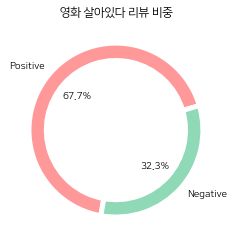

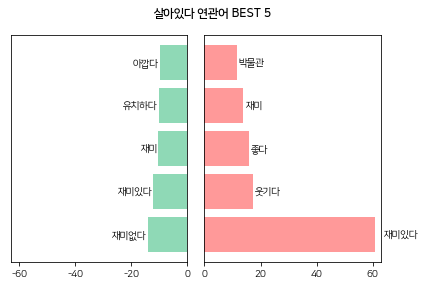

In [125]:
alive.visualize(pmodel,nmodel)